# 导入相关库

In [1]:
import requests
import json
import re

import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import jieba as jb
import matplotlib.pyplot as plt
import itertools
plt.rcParams['font.sans-serif']="SimHei"
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings('ignore')
#要爬取的新闻分类地址国内、国际、军事、航空、科技
url_list={'国内':[ 'https://temp.163.com/special/00804KVA/cm_guonei.js?callback=data_callback',
                   'https://temp.163.com/special/00804KVA/cm_guonei_0{}.js?callback=data_callback'],
         '国际':['https://temp.163.com/special/00804KVA/cm_guoji.js?callback=data_callback',
                 'https://temp.163.com/special/00804KVA/cm_guoji_0{}.js?callback=data_callback'],
         '军事':['https://temp.163.com/special/00804KVA/cm_war.js?callback=data_callback',
               'https://temp.163.com/special/00804KVA/cm_war_0{}.js?callback=data_callback'],
         '航空':['https://temp.163.com/special/00804KVA/cm_hangkong.js?callback=data_callback&a=2',
               'https://temp.163.com/special/00804KVA/cm_hangkong_0{}.js?callback=data_callback&a=2'],
         '科技':['https://tech.163.com/special/00097UHL/tech_datalist.js?callback=data_callback',
              'https://tech.163.com/special/00097UHL/tech_datalist_0{}.js?callback=data_callback']}

# 爬取数据

In [2]:
def parse_class(url):
    '''获取分类下的新闻'''
    req=requests.get(url)
    text=req.text
    res=re.findall("title(.*?)\\n",text)
    #去除不规范的符号
    for i in range(len(res)):
        res[i]=re.sub("\'|\"|\:|'|,|","",res[i])
    return res
titles=[]
categories=[]
def get_result(url):
    global titles,categories
    temp=parse_class(url)
    if temp[0]=='>网易-404</title>':
        return False
    print(url)
    titles.extend(temp)
    temp_class=[key for i in range(len(temp))]
    categories.extend(temp_class)
    return True

for key in url_list.keys():
    #按分类分别爬取
    print("=========正在爬取{}新闻===========".format(key))
    #遍历每个分类中的子链接
    #首先获取首页
    get_result(url_list[key][0])
    #循环获取加载更多得到的页面
    for i in range(1,10):
        try:
            if get_result(url_list[key][1].format(i)):
                pass
            else:
                continue
        except:
            break
print("爬取完毕！")

=========正在爬取国内新闻===========
https://temp.163.com/special/00804KVA/cm_guonei.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_02.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_03.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_04.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_05.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_06.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_07.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guonei_08.js?callback=data_callback
=========正在爬取国际新闻===========
https://temp.163.com/special/00804KVA/cm_guoji.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guoji_02.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guoji_03.js?callback=data_callback
https://temp.163.com/special/00804KVA/cm_guoji_04.js?callback=data_callback
https://temp.163.com/special

# 数据合并
 * 由于新闻具有实时性，每天，或者每天的不同时间段会有不同的新闻产生，因此在保存前将此次爬取中与之前保存的数据中重复内容删除再保存，以达到扩充数据集的目的

In [3]:
new=pd.DataFrame({
    "新闻内容":titles,
    "新闻类别":categories
})
old=pd.read_csv("新闻数据集.csv",encoding='gbk',engine='python')
def update(old,new):
    '''
    更新数据集：将本次新爬取的数据加入到数据集中（去除掉了重复元素）
    '''
    data=new.append(old)
    data=data.drop_duplicates()
    return data
print("更新数据集...")
df=update(old,new)
df.to_csv("新闻数据集.csv",index=None,encoding='gbk')
print("更新完毕，共有数据:",df.shape[0],"条")
df.head()

更新数据集...


UnicodeEncodeError: 'gbk' codec can't encode character '\ufffd' in position 8: illegal multibyte sequence

Text(0.5,1,'各个类别新闻爬取数目统计')

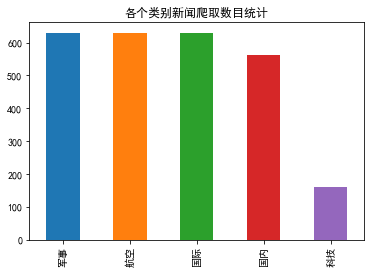

In [5]:
df.新闻类别.value_counts().plot(kind='bar')
plt.title("各个类别新闻爬取数目统计")

# 数据清洗
   * 去标点符号
   * 去停用词
   * 去数字
   * 分词

In [6]:
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding="UTF-8").readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("./stop_words.txt")
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['新闻内容'].apply(remove_punctuation)
#分词，并过滤停用词

df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
print("数据预处理完毕！")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lzh\AppData\Local\Temp\jieba.cache
Loading model cost 0.681 seconds.
Prefix dict has been built successfully.


数据预处理完毕！


## TF-IDF转化，建立朴素贝叶斯模型

In [7]:
#转词向量
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_review)
labels = df.新闻类别
#划分训练集
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.2,random_state=0)
model=MultinomialNB().fit(x_train,y_train)
y_pred=model.predict(x_test)
print("模型训练完毕！")

模型训练完毕！


# 模型评估
 * 混淆矩阵
 * 分类评估报告

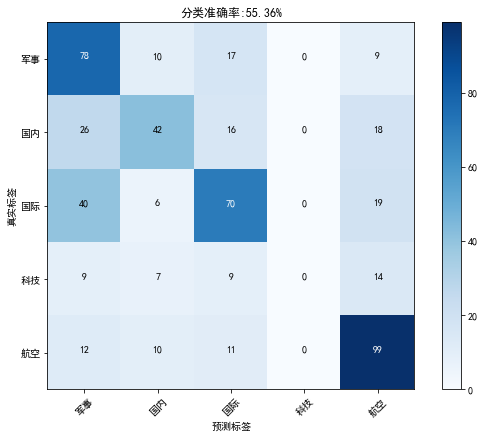

分类评估报告如下:

             precision    recall  f1-score   support

         军事       0.47      0.68      0.56       114
         国内       0.56      0.41      0.47       102
         国际       0.57      0.52      0.54       135
         科技       0.00      0.00      0.00        39
         航空       0.62      0.75      0.68       132

avg / total       0.52      0.55      0.53       522



In [8]:
# 绘制混淆矩阵函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()
class_names=['军事','国内','国际','科技','航空']
cm= confusion_matrix(y_test, y_pred)
title="分类准确率:{:.2f}%".format(accuracy_score(y_test,y_pred)*100)
plot_confusion_matrix(cm,classes=class_names,title=title)
print("分类评估报告如下:\n")
print(classification_report(y_test,y_pred))